In [1]:
%load_ext autoreload 
import glob
import nibabel
import numpy as np
import cc3d

import torch 
from torch.nn import functional as F

import re
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.core.debugger import set_trace
import os
import shutil
from collections import defaultdict
from utils import load, create_dicts, normalize_, video, video_comparison
from IPython.core.display import display, HTML

%autoreload 2

In [2]:
def patch_bbox_size(label_tensor):
    
    '''
    label_tensor - np.ndarray, with size: [H,W,D], and values in {0,1}
    '''
    
    labels_out = cc3d.connected_components(label_tensor, connectivity=26)
    u, c = np.unique(labels_out, return_counts=True)
    
    label_info[label]['cc3d'] = [u,c]
        
    mask = labels_out == 1
    
    X,Y,Z = label_tensor.shape
    
    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask]
    
    # fcd center
    center = xyz_grid.mean(0).astype(int)
    
    # fcd bbox sizes
    dx = (np.sum(mask, axis=(1,2)) > 0).sum()
    dy = (np.sum(mask, axis=(0,2)) > 0).sum()
    dz = (np.sum(mask, axis=(0,1)) > 0).sum()
    
    return center, dx,dy,dz

In [17]:
labels_components = np.load('metadata/label_info.npy', allow_pickle=True).item()
nonsingle_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

labels_broken = {'55','54', '47','43','37','33','25','12', '9','6','3','70NS','73NS', '73NS',
                  'n42','n30', 'n27', 'n31', 'n20', 'n10', 'n8', 'n3',
                 }.union(nonsingle_component_keys)

len(labels_broken)

34

In [18]:
pirogov_labels = set(filter(lambda x: len(re.findall('^\d+',x)) > 0 , labels_components.keys()))
labels_broken = labels_broken.union(pirogov_labels)

In [19]:
root = '/media/tom/ibulygin/fcd_data/radiologist/'
root_label = os.path.join(root, 'label')

feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii.gz'),
#       'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
#       'curv':os.path.join(root, 'curv/norm-{label}.nii'),
#       'sulc':os.path.join(root, 'sulc/norm-{label}.nii'),
#       'thickness':os.path.join(root, 'thickness/norm-{label}.nii'),
#       'bT1':os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'),
#       'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'),
#       'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
#       'T2':os.path.join(root, 'T2/{label}.nii'),
#       'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
#       'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
#       'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
#       'entropy':os.path.join(root, 'entropy/n_sub-{label}_entropy.nii.gz'),
#       'cr':os.path.join(root, 'fmriprep/sub-{label}/anat/*n_T2_CR-{label}.nii.gz')
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates,
                         label_extractor=lambda x: x.split('.')[0],
                         broken_labels=labels_broken) # labels_broken

In [20]:
len(paths_dict)

84

In [21]:
labels_sums_nG = np.array([load(v)['label'].sum() for k,v in tqdm(paths_dict.items())])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:38<00:00,  2.16it/s]


In [22]:
# labels_sums = np.array([load(v)['label'].sum() for k,v in tqdm(paths_dict.items())])

In [ ]:
labels_sums

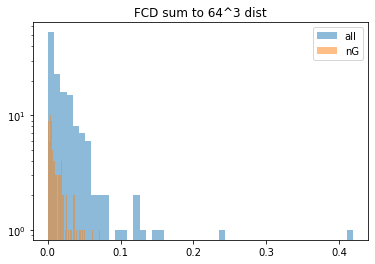

In [28]:
plt.hist(labels_sums/(64**3), bins=50, alpha=0.5, label='all')
plt.hist(labels_sums_nG/(64**3), bins=50, alpha=0.5, label='nG')
plt.yscale('log')
plt.legend()
plt.title('FCD sum to 64^3 dist')
plt.show()

In [34]:
np.percentile(labels_sums_nG/(64**3), 99)

0.06243641701224291

# FCD distribution

In [63]:
# label_tensor_mean = torch.zeros(1,1,128,128,128)
# brain_tensor_mean = torch.zeros(1,1,128,128,128)

# for k,v in tqdm(paths_dict.items()):
#     data = load(v)
#     label_tensor_mean += F.interpolate(torch.tensor(data['label'][None,None,...]), [128,128,128])
#     brain_tensor_mean += F.interpolate(torch.tensor(data['T1w'][None,None,...]), [128,128,128])
    
# label_tensor_mean = label_tensor_mean/label_tensor_mean.max()
# brain_tensor_mean = brain_tensor_mean/brain_tensor_mean.max()

In [57]:
plt.ioff()
camera = video(brain_tensor_mean[0,0].numpy(),
               label_tensor_mean[0,0].numpy(),
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Visualization

In [7]:
brains = {}
target_labels = {}

for k,v in tqdm(paths_dict.items()):
    brain = nibabel.load(v['T1w']).get_fdata()*nibabel.load(v['mask']).get_fdata()
    label = nibabel.load(v['label']).get_fdata()
    y_split = label.sum(axis=(0,-1)).argmax()
    brains[k] = brain[:,y_split,:]
    target_labels[k] = label[:,y_split,:]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [04:57<00:00,  1.68s/it]


In [8]:
labels = list(brains.keys())

# Comparison 

In [67]:
# orig_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_desc-preproc_T1w.nii.gz'
# orig_mask_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_desc-brain_mask.nii.gz'

# brain = nibabel.load(orig_path).get_fdata()
# mask = nibabel.load(orig_mask_path).get_fdata()
# brain_strip = brain*mask

# plt.ioff()
# camera = video(brain,
# #                result['label'],
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [68]:
# brain_light_1 = load(paths_dict['G133'])
# brain_dark_1 = load(paths_dict['18'])

# brain_light_2 = load(paths_dict['n26'])
# brain_dark_2 = load(paths_dict['34'])

In [69]:
# brain_l_1 = normalize_(brain_light_1['T1w'] * brain_light_1['mask'])
# brain_d_1 = normalize_(brain_dark_1['T1w'] * brain_dark_1['mask'])

# brain_l_2 = normalize_(brain_light_2['T1w'] * brain_light_2['mask'])
# brain_d_2 = normalize_(brain_dark_2['T1w'] * brain_dark_2['mask'])


In [70]:
# plt.imshow(brain_l_1[:,100,:])

In [71]:
# plt.imshow(brain_d_1[:,100,:])

In [72]:
# plt.hist(brain_l_1.flatten(), bins=100, alpha=0.5)
# plt.hist(brain_l_2.flatten(), bins=100, alpha=0.5)
# plt.yscale('log')
# plt.show()

In [73]:
# plt.hist(brain_l_1.flatten(), bins=100, alpha=0.5)
# plt.hist(brain_d_1.flatten(), bins=100, alpha=0.5)
# plt.yscale('log')
# plt.show()

In [74]:
# plt.hist(brain_d_1.flatten(), bins=100, alpha=0.5)
# plt.hist(brain_d_2.flatten(), bins=100, alpha=0.5)
# plt.yscale('log')
# plt.show()

In [9]:
classes = ['^\d+', 'n\d+', 'G\d+']
classes_dict = {}

for c in classes:
    classes_dict[c] = list(filter(lambda x: len(re.findall(c, x)) > 0, labels))    

In [10]:
for k,v in classes_dict.items():
    print(k, len(v))

^\d+ 82
n\d+ 78
G\d+ 17


# Pirogov

In [82]:
# plt.ion()
# labels = list(brains.keys())
# fig, axes = plt.subplots(ncols=9, nrows=10, 
#                          sharex=True, sharey=True, dpi=300, figsize=(10,18))

# for i,ax in enumerate(axes.flatten()):
#     try:
#         key = classes_dict['^\d+'][i]
#         ax.imshow(brains[key])
#         ax.set_title(key, fontsize=10)
#     except:
#         pass
# plt.tight_layout()
# plt.show()

# Alexeev

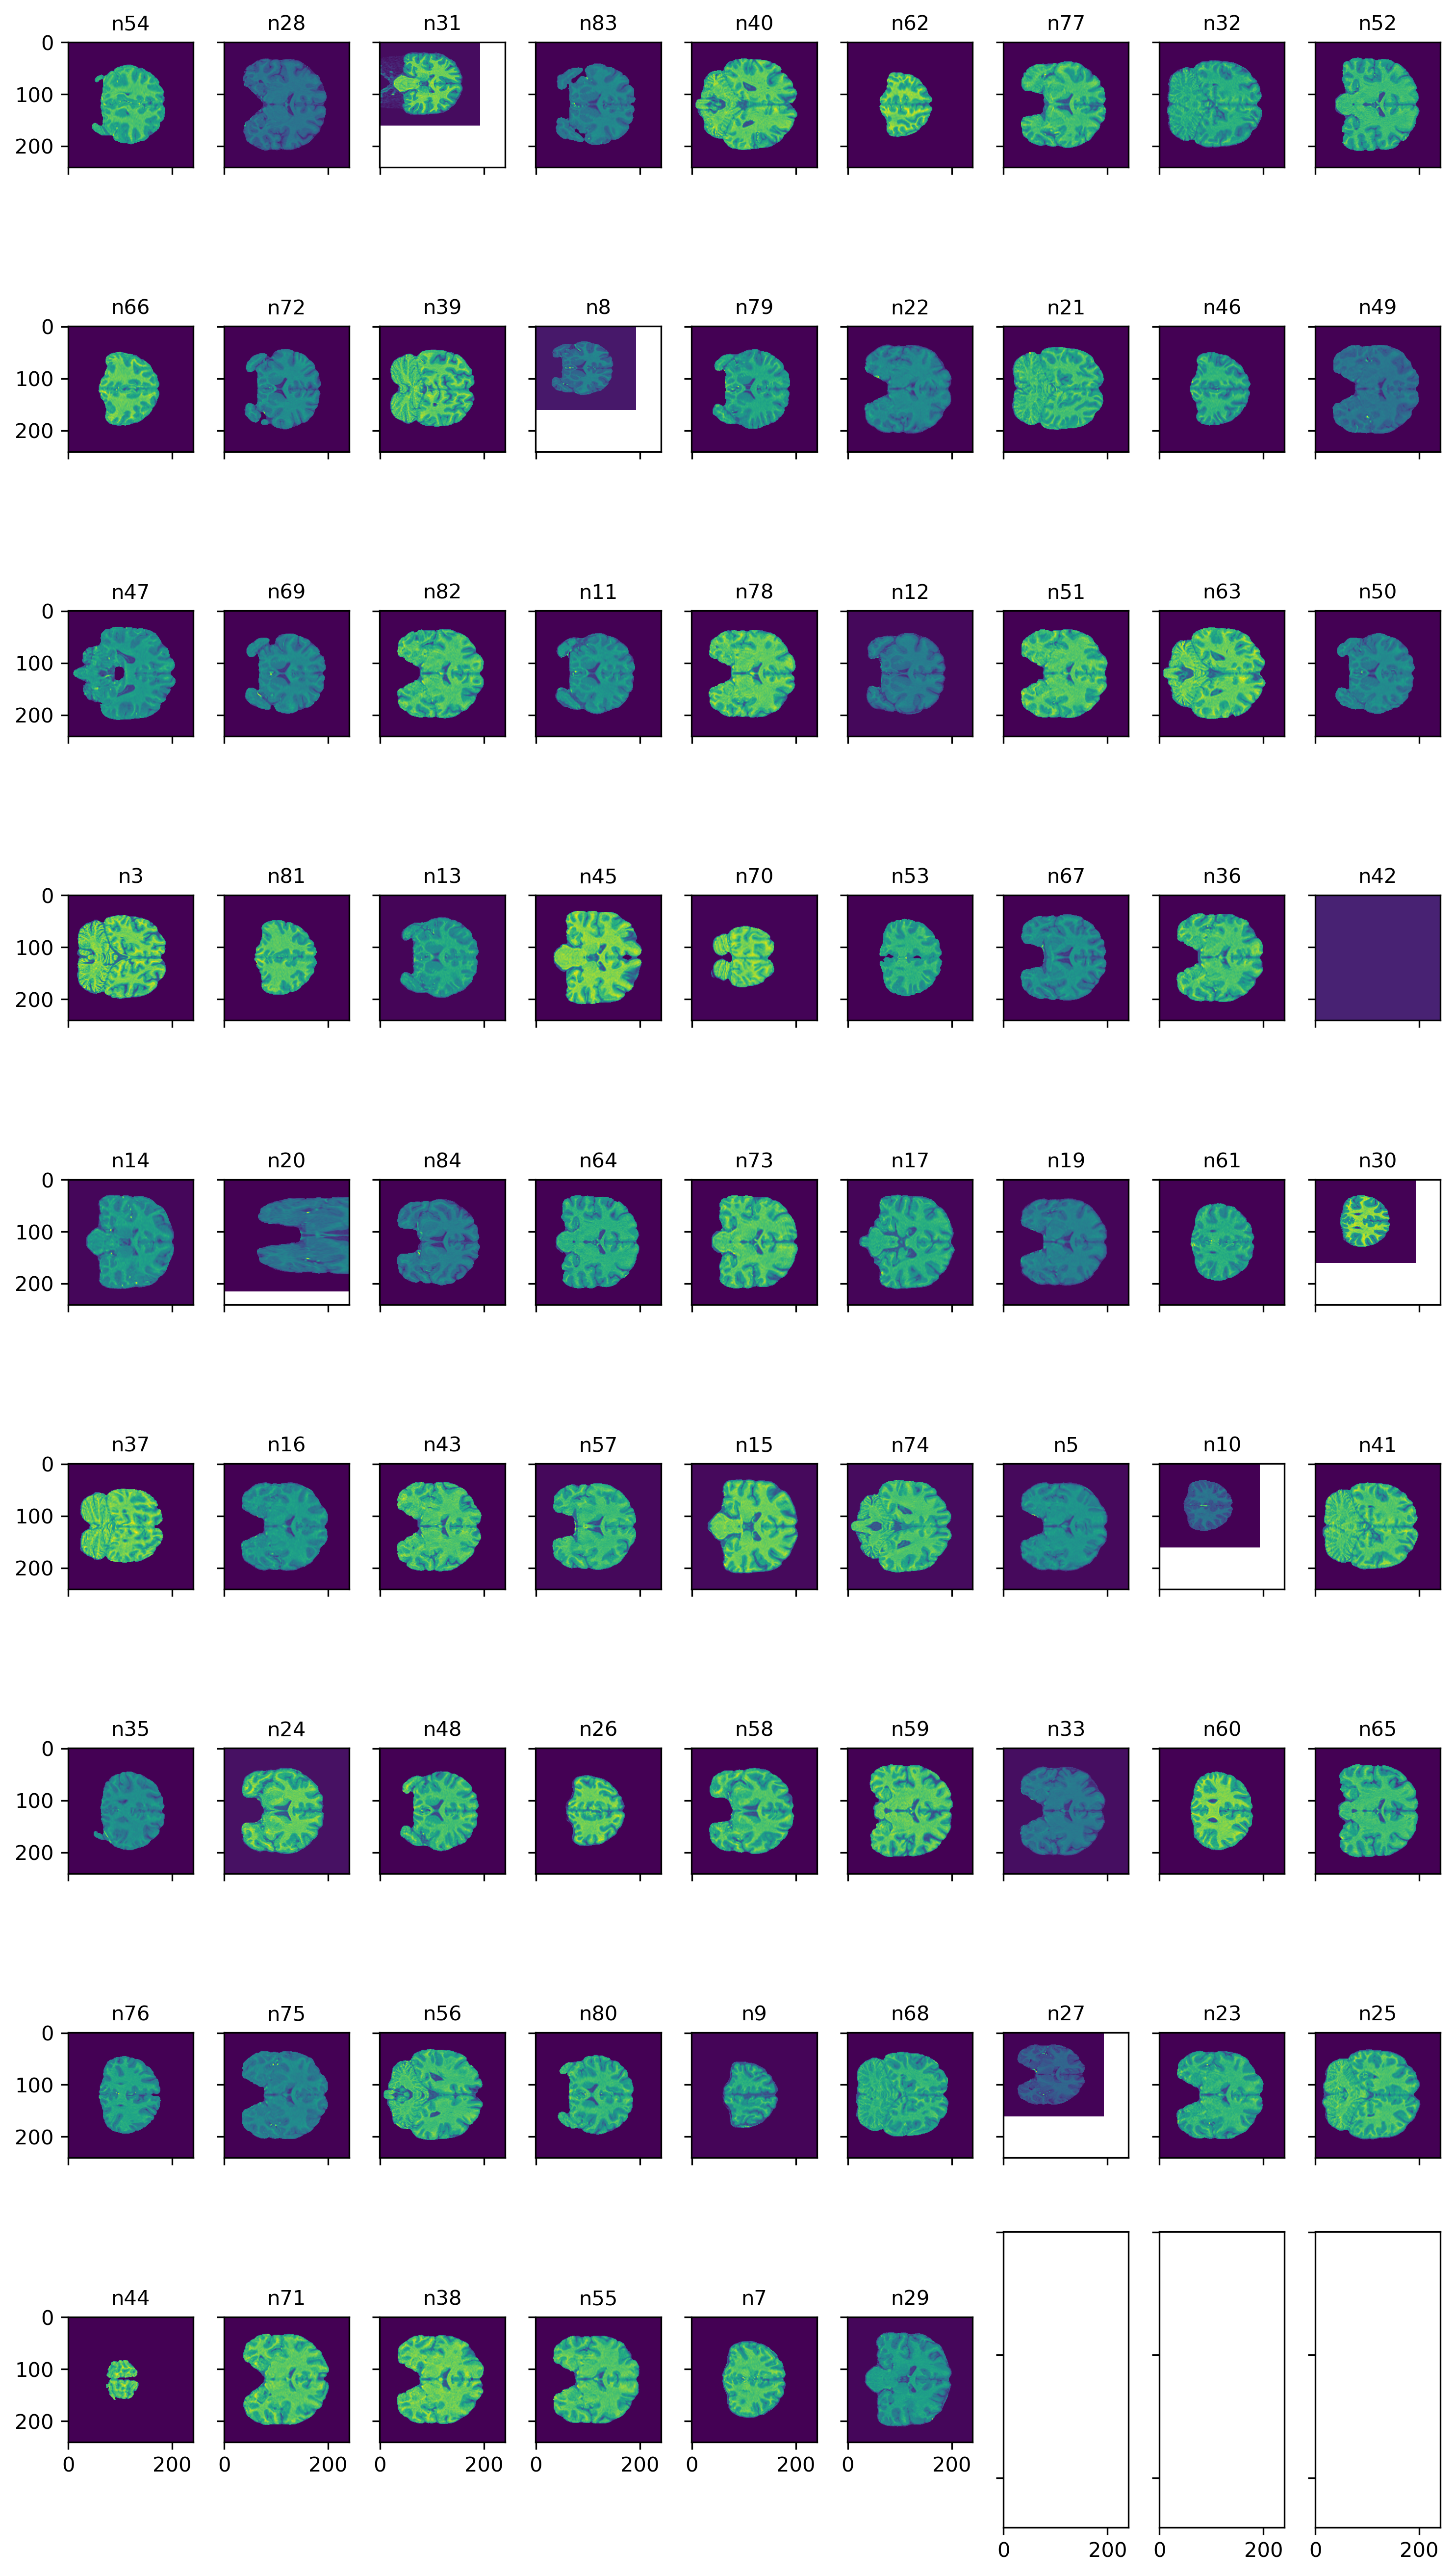

In [11]:
plt.ion()

fig, axes = plt.subplots(ncols=9, nrows=9, 
                         sharex=True, sharey=True, dpi=300, figsize=(10,18))

for i,ax in enumerate(axes.flatten()):
    try:
        key = classes_dict['n\d+'][i]
        ax.imshow(brains[key])
        ax.set_title(key, fontsize=10)
    except:
        pass
plt.tight_layout()
plt.show()

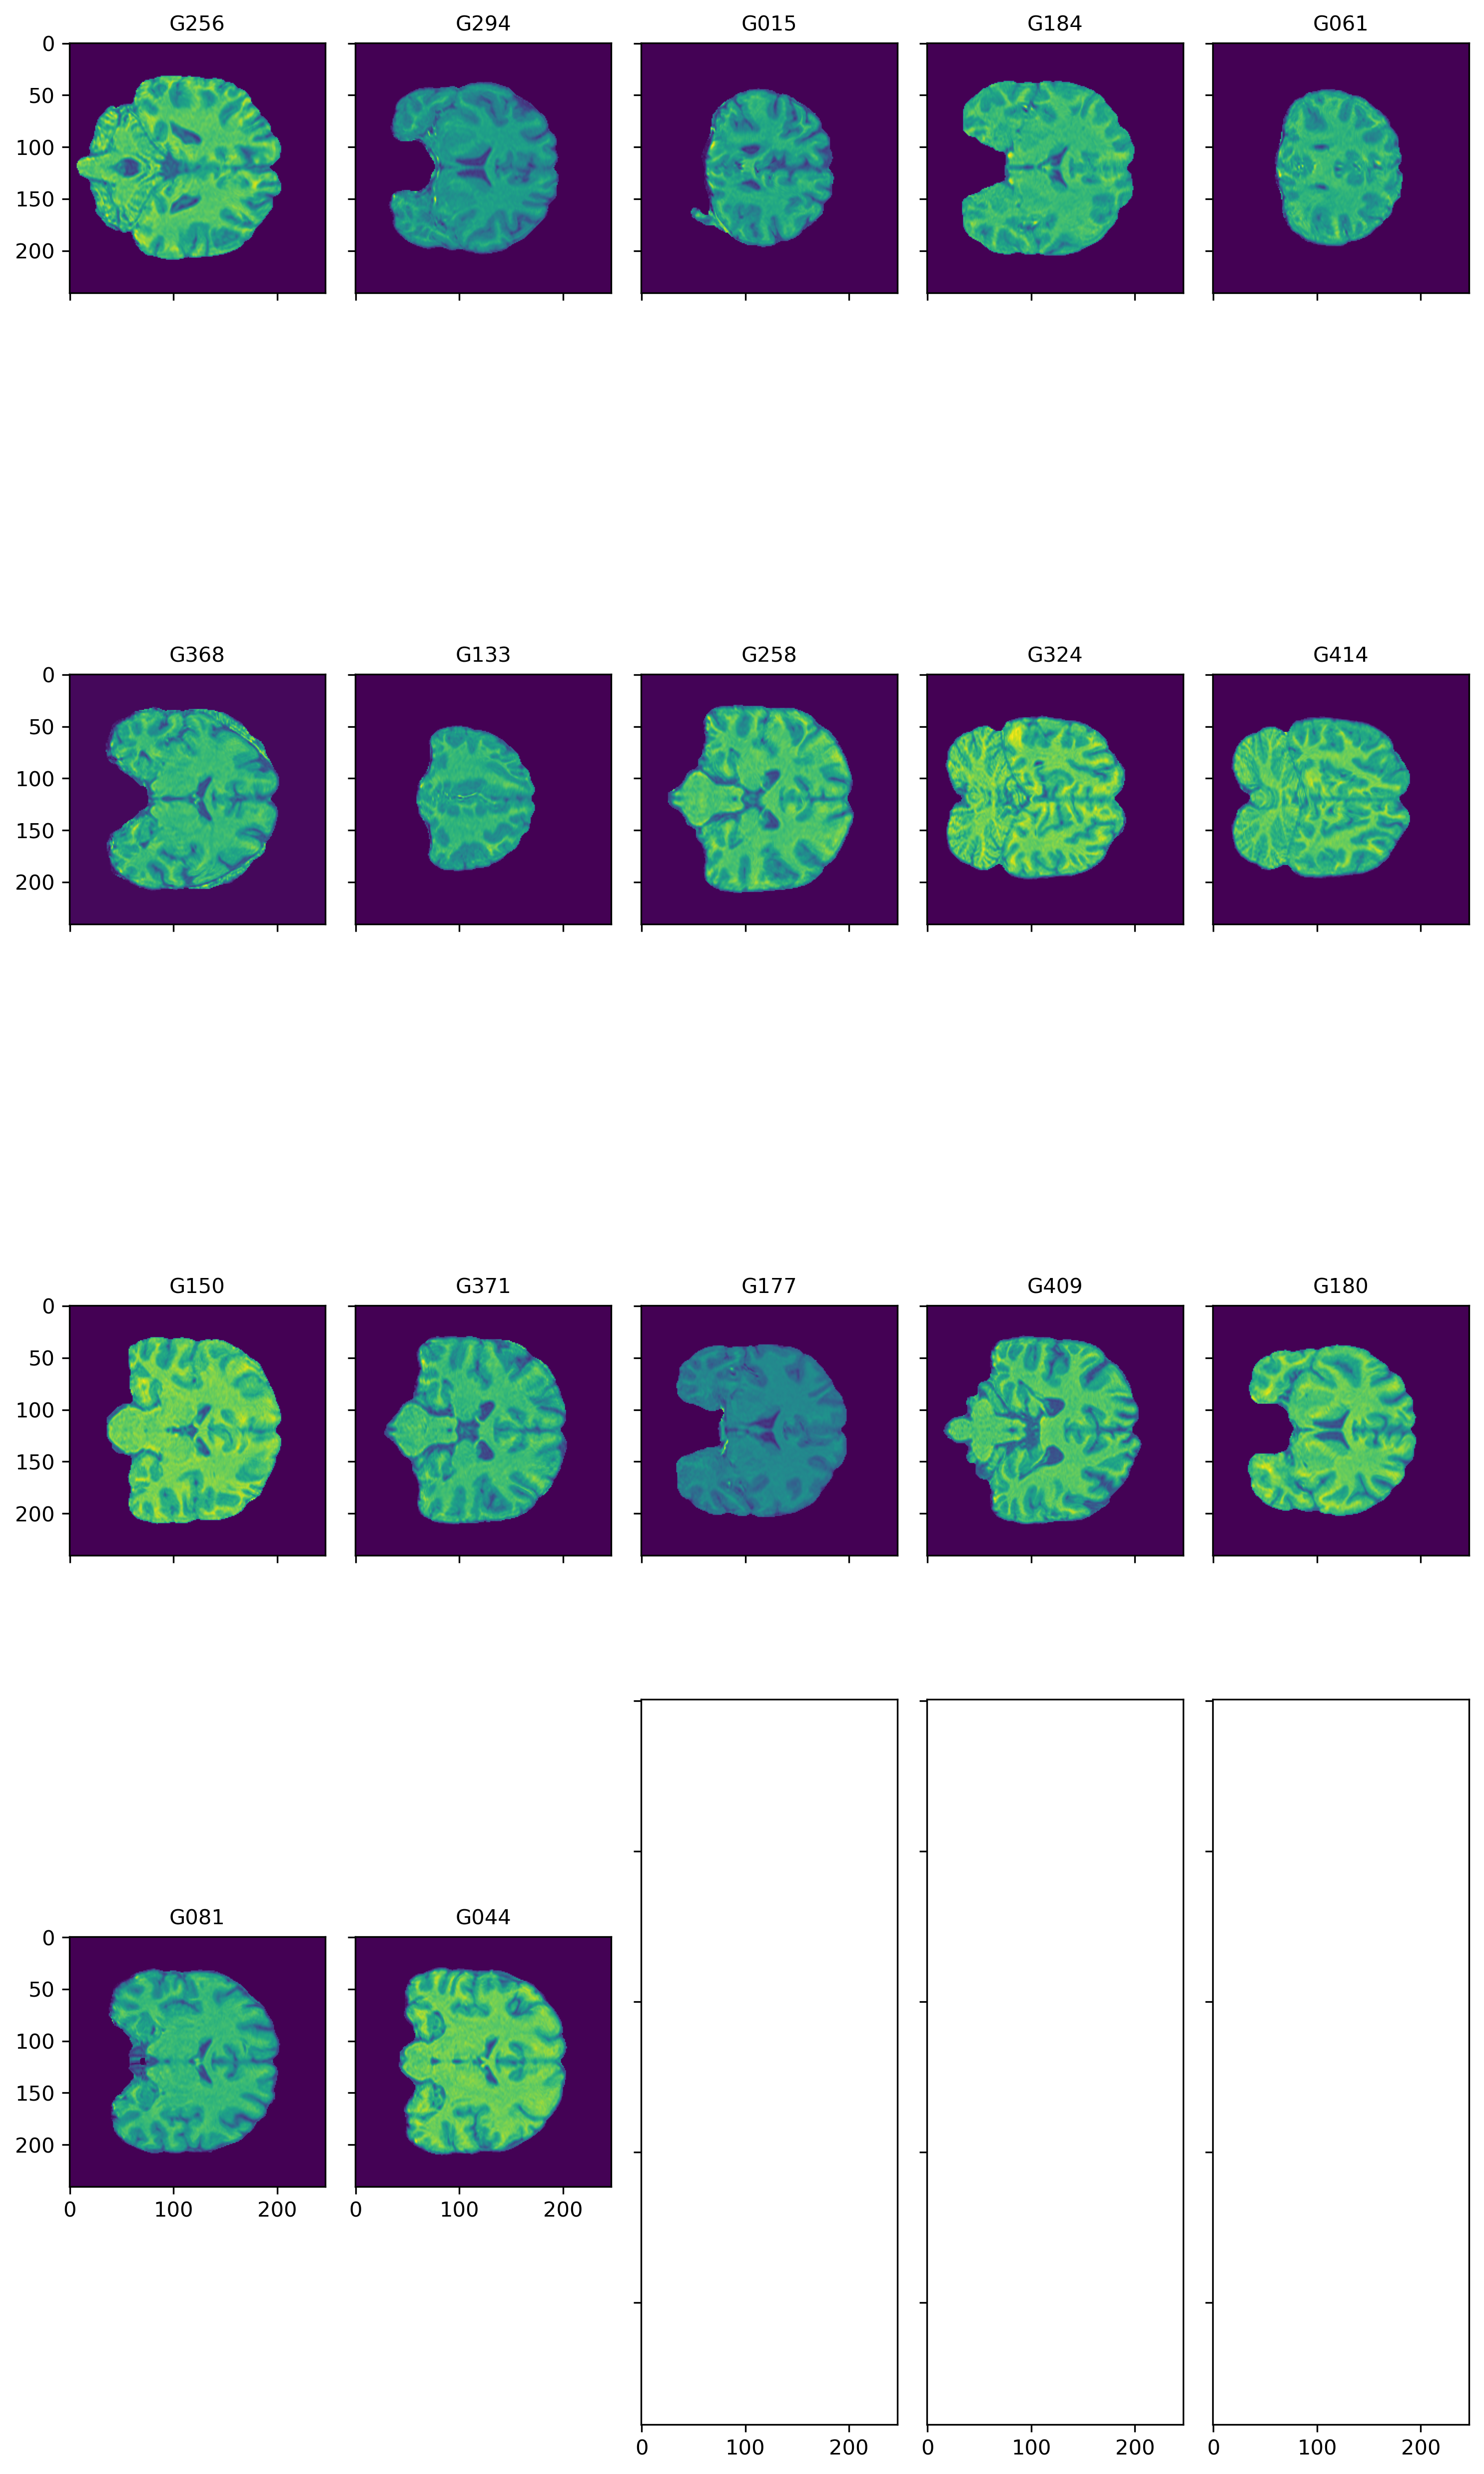

In [12]:
plt.ion()
labels = list(brains.keys())
fig, axes = plt.subplots(ncols=5, nrows=4, 
                         sharex=True, sharey=True, dpi=300, figsize=(10,18))

for i,ax in enumerate(axes.flatten()):
    try:
        key = classes_dict['G\d+'][i]
        ax.imshow(brains[key])
        ax.set_title(key, fontsize=10)
    except:
        pass
plt.tight_layout()
plt.show()

Problems at 13.04.2021:
 ['n42', 'n83', 'n30', 'n8','n20','n10','n31','n27']

# Connected components

In [59]:
len(paths_dict)

143

In [17]:
label_info = defaultdict(dict)

for label, pdict in tqdm(paths_dict.items()):
    
    mask_tensor = nibabel.load(pdict['mask']).get_fdata() > 0
    mask_tensor = mask_tensor.astype(int)

    label_tensor = nibabel.load(pdict['label']).get_fdata() * mask_tensor
    label_tensor = np.array(label_tensor) > 0
    
    center,dx,dy,dz = patch_bbox_size(label_tensor)
    
    label_info[label]['d_s'] = [dx,dy,dz]
    label_info[label]['center'] = center


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [06:20<00:00,  2.15s/it]


In [18]:
nonsingle_component_keys = {k for k,v in label_info.items() if len(v['cc3d'][0]) != 2}

In [19]:
nonsingle_component_keys

{'15',
 '2',
 '36',
 '5',
 '54',
 '58',
 '61',
 '72NS',
 '83',
 '85NS',
 '87NS',
 'n50',
 'n53',
 'n56'}

In [20]:
np.save('metadata/label_info', label_info)

In [24]:
d_max = []
k_max = []
for k,v in labels_components.items():
    if 'd_s' in v.keys():
        d_max.append(max(v['d_s']))
        k_max.append(k)

In [27]:
k_max[np.argmax(d_max)]

'n20'

In [36]:
max(d_max)

90

In [28]:
labels_components['n20']

{'cc3d': [array([0, 1], dtype=uint16), array([56343243,    42657])],
 'd_s': [39, 90, 73],
 'center': array([ 73, 336, 111])}

In [30]:
brain,mask,label = load(paths_dict['n20'])

In [32]:
brain.shape, label.shape

((215, 558, 470), (215, 558, 470))

In [37]:
from skimage import morphology

In [45]:
label_e = morphology.binary_erosion(label).astype(int)

In [47]:
label_e.sum() / label.sum()

0.7763790233724829

In [46]:
plt.ioff()
camera = video(brain,
               label_e,
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation